# Survive your commuting
INTRO: data from 1979 to 2015 etc.

## To do:
+ Explore data and deal with Nan values, outsanding values etc
+ Check whether we can work with all periodes (in terms of volume of data + consistency between datasets ?)
+ Categorize features (date, position etc.) and choose relevant ones (nice and easy to use + information)
+ Turn data into a format we can work with (dummy variables, easy to visualize, date format etc.)
+ function which returns the categorical value of dummified value

## Somes questions we can answer:
+ Accident per age and gender (cliché: young, men)
+ Casualties per age  and gender(cliché: children & elderlies)
+ Weather and road conditions dependency
+ passenger: safest place ? ou la place du mort (cars and bus)
+ home area type: accidents at home or in different area ? (citadins duper à la campagne et vice versa)
+ dates linked to special events etc.

+ nice viz (maps vith every accidents (comme pour la dataset français))

In [9]:
#import
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [100]:
#Global
DATA_FOLDER0514 = './data/Stats19_Data_2005-2014/'
DATA_FOLDER7904 = './data/Stats19-Data1979-2004/'

#columns we want to extract from the accidents file
acc_cols = [#Space and time context
            'Date','Time', 'Longitude', 'Latitude','Day_of_Week',
            #Identifier
            'Accident_Index', 
            #Police force related
            'Police_Force', 'Local_Authority_(District)', 'Local_Authority_(Highway)','Did_Police_Officer_Attend_Scene_of_Accident',
            #Casualties
            'Accident_Severity', 'Number_of_Casualties','Number_of_Vehicles',
            #Road conditions and traffic signalisations
            '1st_Road_Class', '1st_Road_Number', 'Road_Type', 'Speed_limit', 'Junction_Detail', 'Junction_Control',
            '2nd_Road_Class', '2nd_Road_Number',
            #Pedestrian 
            'Pedestrian_Crossing-Human_Control', 'Pedestrian_Crossing-Physical_Facilities', 
            #Visibility and road conditions
            'Light_Conditions', 'Weather_Conditions', 'Road_Surface_Conditions', 'Special_Conditions_at_Site', 'Carriageway_Hazards',
            'Urban_or_Rural_Area', 
            #'Location_Easting_OSGR','Location_Northing_OSGR', 'LSOA_of_Accident_Location',
           ]

#features legends
LEGENDS = pd.read_excel(DATA_FOLDER7904 + 'Road-Accident-Safety-Data-Guide-1979-2004.xls',
                        sheet_name = None,
                       )

In [115]:
#HELPERS

#TO DO: colors set (la c'est immonde), remplacer les numéros de jours par les vrais jours
def plot_distrib(acc, group = "Day_of_Week", colname = "Accident_Index", ax = None):
    """
    Plot the distribution of colname per group
    """
    if colname == 'Accident_Index':
        acc.groupby([group])[colname].count().plot.bar(x = group, 
                                                       y = colname,
                                                       title = colname + ' distribution per '+ group +', 0514',
                                                       ax = ax)
    else:
        acc.groupby([group])[colname].sum().plot.bar(x = group, 
                                                     y = colname,
                                                     title = colname + ' distribution per '+ group +', 0514',
                                                     ax = ax)                        


In [85]:
#load data
if False:
    accidents = pd.read_csv(DATA_FOLDER0514 + "Accidents0514.csv", 
                            usecols = acc_cols,
                           parse_dates = [["Date","Time"]],
                           )

    casualties = pd.read_csv(DATA_FOLDER0514 + "Casualties0514.csv",
                            )


> We know that the names of the legends do not fit the name of the features, we need to replace whitespace by underscore.

In [117]:
#modify legend names to match with df features
for k in [k for k in LEGENDS.keys()]:
    LEGENDS[k.replace(' ', '_')] = LEGENDS.pop(k)

LEGENDS.keys()

odict_keys(['Introduction', 'Export_Variables', 'Police_Force', 'Accident_Severity', 'Day_of_Week', 'Local_Authority_(District)', 'Local_Authority_(Highway)', '1st_Road_Class', 'Road_Type', 'Junction_Detail', 'Junction_Control', '2nd_Road_Class', 'Ped_Cross_-_Human', 'Ped_Cross_-_Physical', 'Light_Conditions', 'Weather', 'Road_Surface', 'Special_Conditions_at_Site', 'Carriageway_Hazards', 'Urban_Rural', 'Police_Officer_Attend', 'Vehicle_Type', 'Towing_and_Articulation', 'Vehicle_Manoeuvre', 'Vehicle_Location', 'Junction_Location', 'Skidding_and_Overturning', 'Hit_Object_in_Carriageway', 'Veh_Leaving_Carriageway', 'Hit_Object_Off_Carriageway', '1st_Point_of_Impact', 'Was_Vehicle_Left_Hand_Drive', 'Journey_Purpose', 'Sex_of_Driver', 'Age_Band', 'Vehicle_Propulsion_Code', 'Casualty_Class', 'Sex_of_Casualty', 'Casualty_Severity', 'Ped_Location', 'Ped_Movement', 'Car_Passenger', 'Bus_Passenger', 'Ped_Road_Maintenance_Worker', 'Casualty_Type', 'IMD_Decile', 'Home_Area_Type'])

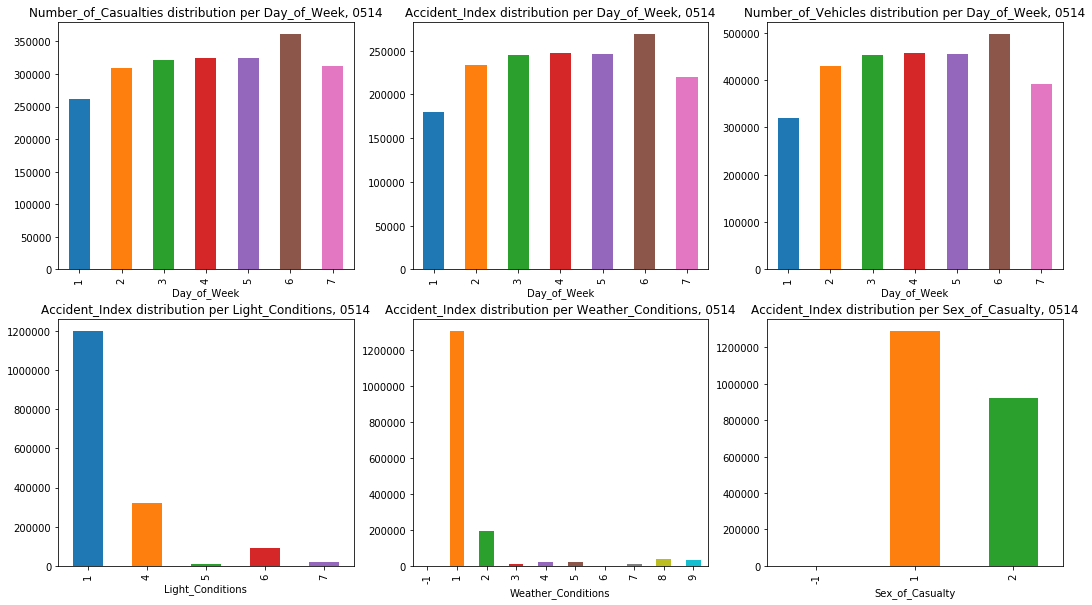

In [58]:
#Weekly distribution
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
plot_distrib(accidents, colname = "Number_of_Casualties", ax = axes[0][0])
plot_distrib(accidents, ax = axes[0][1])
plot_distrib(accidents, colname = "Number_of_Vehicles", ax = axes[0][2])
plot_distrib(accidents, group = "Light_Conditions", ax = axes[1][0])
plot_distrib(accidents, group = "Weather_Conditions", ax = axes[1][1])
plot_distrib(casualties, group = "Sex_of_Casualty", ax = axes[1][2])

> Almost the same distri for the week. But Sunday is the lowest (people are doing nothing at home ?) and Friday is the worst (end of week = tired + party + départ en we ?)

> Plus de  blessés mais moins de véhicules le Dimanche que le Lundi, car le Dimanche = voiture en famille aka moins de voitures alors que Lundi = commute = tout seul dans sa caisse

> On va avoir besoin de diviser par la fréquence de chaque conditions => besoin de plus de données

> ce serait stylé d'avoir une couleur par jour, qui ne change pas

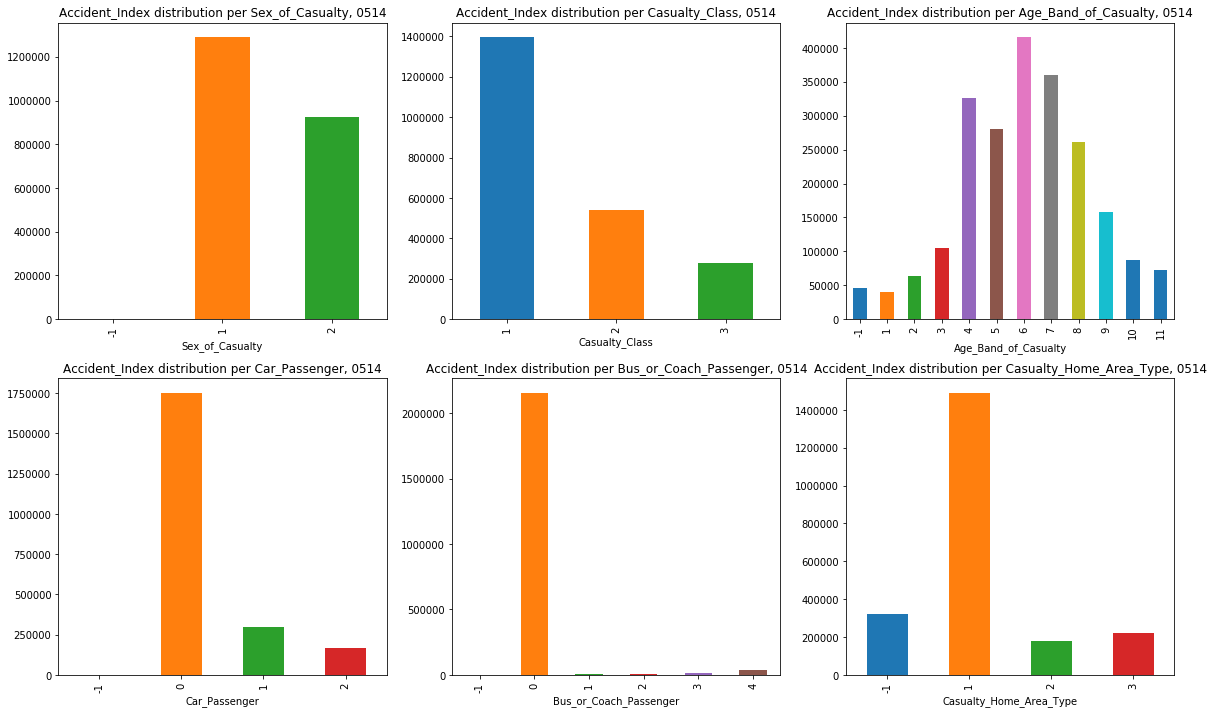

In [59]:
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
plot_distrib(casualties, group = "Sex_of_Casualty", ax = axes[0][0])
plot_distrib(casualties, group = "Casualty_Class", ax = axes[0][1])
plot_distrib(casualties, group = "Age_Band_of_Casualty", ax = axes[0][2])
plot_distrib(casualties, group = "Car_Passenger", ax = axes[1][0])
plot_distrib(casualties, group = "Bus_or_Coach_Passenger", ax = axes[1][1])
plot_distrib(casualties, group = "Casualty_Home_Area_Type", ax = axes[1][2])


>Get rid of 0 for car_passenger and bus_passenger